### This IPython notebook defines several variations of convolutional neural networks for channel estimation. The training inputs are the preamble + preamble passed through channel; the predicted output is the channel taps that correspond to the input. We explore several ideas here:
#### (A) multi-scale convolution (learned) filters applied separately to the [preamble input] and to the [preamble thorugh channel] input
#### (B) multi-scale convolution (learned) filters applied to both (e.g., 2D convolution filters)

<pre>
model 1:
   preamble -> conv1_1 -> conv2_1 -> conv3_1 ->\
                                                concat -> conv1 -> fc2 -> channel
   received -> conv1_2 -> conv2_2 -> conv3_2 ->/
   
model 2:
   preamble -> conv1 -> conv2 -> conv3 ->\
                                          concat -> conv1 -> fc2 -> channel
   received -> conv1 -> conv2 -> conv3 ->/
   
model 3:
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc2 -> channel
     [   |        |    ]
</pre>

We make several assumptions about the channel model here as well:
* Channel length is <= 20
* Channel energy (am I saying this correctly?) is 1 (also, does normalizing channel taps by l2 norm ensure this?)
* Channel is sparse (most entries near 0, except for a few spikes)
  * Potential simplifying assumption (maybe include initially?) first entry of channel is 'large'
  
  
Questions: 
1. for my preamble, I am using +/- 1; Nikhil used 1/0 .. which is correct? (It should not matter really for training/testing since it is a simple affine transform between the two, but I want to do the "correct" thing)
2. do my assumptions make sense? for a real model I mean
3. am I adding noise correctly for the SNR I am setting
4. More of a "TODO" but...I am only training and testing on preamble inputs, not additional data -- the reasoning is that for additional data, we really want something that handles sequences (e.g., and RNN) in my opinion and this is more of an exploratoration of convolutional layers here

## ALSO NOTE: I am making a lot of things very modular on purpose..I want to discuss with everyone the problem statement again (I still feel like a lot of things are unclear/ambiguous) and then we can move a lot of this modular code to a rigid "util.py" file that everyone should import from so that we can more easily guarantee correctness and consistency and speed up development time.

In [1]:
# standard imports
import numpy as np
import scipy.signal as sig
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# utility functions...we really should standardize this in a Python file [TODO!!!!]
"""Generates random sequence [1 1 1 -1 1 -1 -1 ...] of length LENGTH."""
def gen_preamble(length=100):
    return np.random.randint(2, size=(1,length))*2 - 1

"""Generates N channels of length LENGTH, each with NUM_TAPS taps. This
   means that NUM_TAPS of the entries will be non-zero, and the rest will
   be 'close' to 0 (e.g., noise). 
   Example below.
   
   >>> np.around(gen_channel(),2)
   >>> array([[-0.08,  0.  , -0.06,  0.02,  0.  ,  0.02, -0.85,  0.05, -0.03,
        -0.07,  0.5 , -0.02, -0.  , -0.05, -0.  ,  0.03, -0.07, -0.04,
        -0.01,  0.08]])"""
def gen_channel(N=1,num_taps=2,length=20):
    ret = np.zeros((N, length))
#     tap_idxs = np.random.randint(length, size=(N, num_taps))
#     tap_vals = ((np.random.randint(10, size=(N, num_taps))+1)*\
#                 (np.random.randint(2, size=(N, num_taps))*2 - 1))\
#                 / 10.
#     for i in range(N):
#         np.put(ret[i], tap_idxs[i], tap_vals[i])
#     ret += 5e-2*np.random.randn(N,length)
    ret += np.random.randn(N,length)
    return ret / np.linalg.norm(ret,axis=1,keepdims=True)

"""Simulates passing data through a noisy channel.
   If SNR == -1, then no noise. Otherwise, uses AWGN model.
   
   Returned value has shape (1, len(channel.T) + len(data.T) - 1).
   With default settings, this means it is (1, 119)."""
def apply_channel(channel, data, snr=-1):
    ret = sig.convolve(data, channel, mode='full')
    if snr > 0:
        ret += (1./np.sqrt(snr)) * np.random.randn(len(ret),1)
    return ret

In [3]:
# functions for networks..should also put this in util.py!
"""Run before building a new network. Rests randomization for repeatability."""
def reset():
    tf.reset_default_graph()
    np.random.seed(0)
    tf.set_random_seed(0)
    
"""Defines the loss function."""
def define_loss(placeholders, loss_type):
    output, correct_output = placeholders
    return tf.reduce_mean(tf.reduce_sum((output-correct_output)**2, axis=1))
    
"""Defines the optimizer."""
def define_optimizer(loss, trainable_weights, optimizer, lr):
    opt = tf.train.AdamOptimizer(lr)
    gradients = opt.compute_gradients(loss, trainable_weights)
    train_step = opt.apply_gradients(gradients)
    return train_step

"""Defines a trainable variable with truncated normal initialization."""
def define_variable(name, shape, stddev):
    var = tf.get_variable(name, shape, initializer=
                    tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32),
                    dtype=tf.float32)
    return var
"""* 'preamble_len' : length of preamble; [default = 100]
   * 'channel_len' : length of channel; [default = 20]
   * 'use_max_pool': True to use max pooling in first part of net; [default = False]
   * 'loss' : loss function to use
   * 'optimizer' : optimizer to use
   * 'lr' : base learning rate
   
   """
def load_params(params, default_params):
    if params == None:
        params = {}
    for k in default_params.keys():
        if k not in params:
            params[k] = default_params[k]
    return params

In [4]:
# training a network
def train_net(params=None):
    default_params = {'network_option':build_network1, 'num_iter':1001, 'batch_size':10,
                      'snr':-1, 'num_preambles':1, 'fixed_preamble':True, 'num_taps':2, 
                      'preamble_len':100, 'channel_len':20}
    params = load_params(params, default_params)
    
    reset()
    inputs, outputs, weights, loss, train = params['network_option'](params)
    num_iter=params['num_iter']
    batch_size=params['batch_size']
    # use a single fixed preamble
    if params['fixed_preamble']:
        preambles=[gen_preamble(length=params['preamble_len']) for _ in range(params['num_preambles'])]
    
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    loss_over_time = []
    iteration_loss = []
    for i in range(0,num_iter):
        if params['fixed_preamble']:
            preamble = preambles[np.random.randint(len(preambles))]
        else:
            preamble = gen_preamble(length=params['preamble_len'])
        # generate data
        channels = gen_channel(N=params['batch_size'], length=params['channel_len'])
        received = apply_channel(channels, preamble, snr=params['snr'])
        #channels = channels.reshape((params['batch_size'],-1,1))
        received = received.reshape((params['batch_size'],-1,1))[:,:params['preamble_len'],:]

        # get loss BEFORE training (important esp. for evaluating case when non-fixed preamble)
        if i % 100 == 0:
            l = sess.run(loss, feed_dict={inputs[0]:preamble.reshape((1, params['preamble_len'], 1)),
                         inputs[1]:received,
                         inputs[2]:channels})
            
        # train
        sess.run(train, feed_dict={inputs[0]:preamble.reshape((1, params['preamble_len'], 1)),
                         inputs[1]:received,
                         inputs[2]:channels})
        if i % 100 == 0:
            print(i,l)
            loss_over_time.append(l)
            iteration_loss.append(i)
    return inputs, outputs, weights, loss, train, preamble, sess, [iteration_loss, loss_over_time]

## These networks assume 1 fixed preamble.

In [5]:
# define the networks
"""Builds the network [model 1] -- a basic convolution network; use as a base
   for the next network models.
   
   preamble -> conv1_1 -> conv2_1 -> conv3_1 ->\
                                                concat -> conv1 -> fc2 -> channel_est
   received -> conv1_2 -> conv2_2 -> conv3_2 ->/
"""    
def build_network1(params=None):
    default_params = {'use_max_pool':False, 'loss':"", 'optimizer':"", 'lr':1e-4,
                   'filters':[30,30,10,10], 'filter_sizes':[3,3,3,3]}
    params = load_params(params,default_params)
            
    preamble = tf.placeholder(tf.float32, [1, params['preamble_len'], 1], name="preamble_input")
    # use same length as preamble as per discussion on April 12
    received = tf.placeholder(tf.float32, [None, params['preamble_len'], 1], name="received_preamble")
    channel_true = tf.placeholder(tf.float32, [None, params['channel_len']])
    batch_size = tf.shape(received)[0]
    
    inputs=[preamble,received,channel_true]
    outputs=[]
    weights=[]
    
    nets=[preamble,received]
    
    # Process PREAMBLE and RECEIVED separately through convolutions
    num_filters = [1] + params['filters']
    for i in [1,2]:
        net = nets[i-1]
        for j in range(1, len(num_filters)-1):
            num_filter = num_filters[j]
            prev = num_filters[j-1]
            with tf.variable_scope("conv%d_%d" % (j+1, i)) as scope:
                # use same weight initializer for all, and always use 3x_ convolutions
                kernel = define_variable('conv_weights', [params['filter_sizes'][j-1],
                                                          prev, num_filter], 5e-2)
                biases = define_variable('conv_biases', [num_filter], 5e-3)
                weights.extend([kernel, biases])
                # apply network
                net = tf.nn.conv1d(net, kernel, stride=1, padding='SAME')
                net = tf.nn.bias_add(net, biases)
                net = tf.nn.relu(net)
                if params['use_max_pool']:
                    net = tf.layers.max_pooling1d(net, pool_size=3, 
                                                 strides=2, padding='SAME')
        nets[i-1] = net
        
    # Concatenate
    nets[0] = tf.tile(nets[0], [batch_size, 1, 1])
    output = tf.concat(nets, axis=1)
    num_concat_layers = len(params['filter_sizes'])
    with tf.variable_scope("conv1_concat") as scope:
        kernel = define_variable('conv_weights', [params['filter_sizes'][-1], 
                                                  num_filters[-2], num_filters[-1]], 5e-2)
        biases = define_variable('conv_biases', [num_filters[-1]], 5e-3)
        weights.extend([kernel, biases])
        # apply network
        net = tf.nn.conv1d(net, kernel, stride=1, padding='SAME')
        net = tf.nn.bias_add(net, biases)
        net = tf.nn.relu(net)
    with tf.variable_scope("fc2_concat") as scope:
        dim = output.get_shape()[1].value*output.get_shape()[2].value
        batch_size = tf.shape(output)[0]
        
        kernel = define_variable('conv_weights', [dim, params['channel_len']], 5e-2)
        biases = define_variable('conv_biases', [params['channel_len']], 5e-3)
        weights.extend([kernel, biases])
        # apply network
        output = tf.reshape(output, [batch_size, -1])
        output = tf.matmul(output, kernel) + biases
    
    outputs=[output]
    
    loss = define_loss([output, channel_true], params['loss'])
    train = define_optimizer(loss, weights, params['optimizer'], params['lr'])

    return inputs, outputs, weights, loss, train

"""Builds the network [model 2] -- a basic convolution network; use as a base
   for the next network models. [difference from model 1: share initial convolutions]
   
   preamble -> conv1 -> conv2 -> conv3 ->\
                                          concat -> conv1 -> fc2 -> channel_est
   received -> conv1 -> conv2 -> conv3 ->/
   
   
   """
def build_network2(params=None):
    default_params = {'use_max_pool':False, 'loss':"", 'optimizer':"", 'lr':1e-4,
                   'filters':[30,30,10,10], 'filter_sizes':[3,3,3,3]}
    params = load_params(params,default_params)
            
    preamble = tf.placeholder(tf.float32, [1, params['preamble_len'], 1], name="preamble_input")
    # use same length as preamble as per discussion on April 12
    received = tf.placeholder(tf.float32, [None, params['preamble_len'], 1], name="received_preamble")
    channel_true = tf.placeholder(tf.float32, [None, params['channel_len']])
    batch_size = tf.shape(received)[0]
    
    inputs=[preamble,received,channel_true]
    outputs=[]
    weights=[]
    
    nets=[preamble,received]
    
    # Process PREAMBLE and RECEIVED separately through convolutions
    num_filters = [1] + params['filters']
    
    for j in range(1, len(num_filters)-1):
        num_filter = num_filters[j]
        prev = num_filters[j-1]
        with tf.variable_scope("conv%d" % j) as scope:
            # use same weight initializer for all, and always use 3x_ convolutions
            kernel = define_variable('conv_weights', [params['filter_sizes'][j-1],
                                                      prev, num_filter], 5e-2)
            biases = define_variable('conv_biases', [num_filter], 5e-3)
            weights.extend([kernel, biases])
            # apply network
            for i in range(2):
                net = nets[i]
                net = tf.nn.conv1d(net, kernel, stride=1, padding='SAME')
                net = tf.nn.bias_add(net, biases)
                net = tf.nn.relu(net)
                if params['use_max_pool']:
                    net = tf.layers.max_pooling1d(net, pool_size=3, 
                                                 strides=2, padding='SAME')
                nets[i] = net

    # Concatenate
    nets[0] = tf.tile(nets[0], [batch_size, 1, 1])
    output = tf.concat(nets, axis=1)
    with tf.variable_scope("conv1_concat") as scope:
        kernel = define_variable('conv_weights', [params['filter_sizes'][-1],
                                                  num_filters[-2], num_filters[-1]], 5e-2)
        biases = define_variable('conv_biases', [num_filters[-1]], 5e-3)
        weights.extend([kernel, biases])
        # apply network
        net = tf.nn.conv1d(net, kernel, stride=1, padding='SAME')
        net = tf.nn.bias_add(net, biases)
        net = tf.nn.relu(net)
    with tf.variable_scope("fc2_concat") as scope:
        dim = output.get_shape()[1].value*output.get_shape()[2].value
        batch_size = tf.shape(output)[0]
        
        kernel = define_variable('conv_weights', [dim, params['channel_len']], 5e-2)
        biases = define_variable('conv_biases', [params['channel_len']], 5e-3)
        weights.extend([kernel, biases])
        # apply network
        output = tf.reshape(output, [batch_size, -1])
        output = tf.matmul(output, kernel) + biases
    
    outputs=[output]
    
    loss = define_loss([output, channel_true], params['loss'])
    train = define_optimizer(loss, weights, params['optimizer'], params['lr'])

    return inputs, outputs, weights, loss, train

"""Builds the network [model 3] -- a basic convolution network; use as a base
   for the next network models. [difference from model 1: wide convolutions]
   
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc2 -> channel_est
     [   |        |    ]
   
   
   """
def build_network3(params=None):
    default_params = {'use_max_pool':False, 'loss':"", 'optimizer':"", 'lr':1e-4,
                   'filters':[30,30,10,10], 'filter_sizes':[3,3,3,3]}
    params = load_params(params,default_params)
            
    preamble = tf.placeholder(tf.float32, [1, params['preamble_len'], 1], name="preamble_input")
    # use same length as preamble as per discussion on April 12
    received = tf.placeholder(tf.float32, [None, params['preamble_len'], 1], name="received_preamble")
    channel_true = tf.placeholder(tf.float32, [None, params['channel_len']])
    batch_size = tf.shape(received)[0]
    
    temp = tf.tile(preamble, [batch_size, 1, 1])
    network_input = tf.concat([temp, received], axis=2)
    
    inputs=[preamble,received,channel_true]
    outputs=[]
    weights=[]
    
    output = network_input
    
    # Process PREAMBLE and RECEIVED separately through convolutions
    num_filters = [2] + params['filters']
    
    for j in range(1, len(num_filters)):
        num_filter = num_filters[j]
        prev = num_filters[j-1]
        with tf.variable_scope("conv%d" % j) as scope:
            # use same weight initializer for all, and always use 3x_ convolutions
            kernel = define_variable('conv_weights', [params['filter_sizes'][j-1],
                                                      prev, num_filter], 5e-2)
            biases = define_variable('conv_biases', [num_filter], 5e-3)
            weights.extend([kernel, biases])
            # apply network
            output = tf.nn.conv1d(output, kernel, stride=1, padding='SAME')
            output = tf.nn.bias_add(output, biases)
            output = tf.nn.relu(output)
            if params['use_max_pool']:
                output = tf.layers.max_pooling1d(output, pool_size=3, 
                                                 strides=2, padding='SAME')
                
    with tf.variable_scope("fc5") as scope:
        dim = output.get_shape()[1].value*output.get_shape()[2].value
        batch_size = tf.shape(output)[0]
        
        kernel = define_variable('conv_weights', [dim, params['channel_len']], 5e-2)
        biases = define_variable('conv_biases', [params['channel_len']], 5e-3)
        weights.extend([kernel, biases])
        # apply network
        output = tf.reshape(output, [batch_size, -1])
        output = tf.matmul(output, kernel) + biases
    
    outputs=[output]
    
    loss = define_loss([output, channel_true], params['loss'])
    train = define_optimizer(loss, weights, params['optimizer'], params['lr'])

    return inputs, outputs, weights, loss, train

In [83]:
p = {'network_option':build_network1, 'num_iter':10001, 'batch_size':10,
     'snr':1, 'num_preambles':10, 'fixed_preamble':True, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2}
inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)

0 1.0037279
100 0.98956776
200 0.9512513
300 0.77962005
400 0.61969936
500 0.047824774
600 0.11760072
700 0.037142035
800 0.004589699
900 0.00719625
1000 0.0080611035
1100 0.0035805772
1200 0.0079611745
1300 0.00662155
1400 0.0010010331
1500 0.002908986
1600 0.0016021358
1700 0.00520631
1800 0.0022004338
1900 0.0038210829
2000 0.0014425439
2100 0.0026262184
2200 0.00090747065
2300 0.0022067144
2400 0.002198817
2500 0.00094118825
2600 0.0008286202
2700 0.0009087268
2800 0.0011466893
2900 0.0006487703
3000 0.0006030737
3100 0.0012283432
3200 0.00091996824
3300 0.0008483691
3400 0.00049797207
3500 0.0007882418
3600 0.0009207406
3700 0.00064210914
3800 0.00049046177
3900 0.0009397149
4000 0.00019040005
4100 0.00029289076
4200 0.00066643825
4300 0.00053229457
4400 0.0005414066
4500 0.00048874406
4600 0.00055235
4700 0.00031948645
4800 0.00055020256
4900 0.00043909572
5000 0.00040581138
5100 0.0004921703
5200 0.00046432437
5300 0.00045177565
5400 0.00049084425
5500 0.00017822513
5600 0.00028

In [82]:
p = {'network_option':build_network2, 'num_iter':10001, 'batch_size':10,
     'snr':1, 'num_preambles':10, 'fixed_preamble':True, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2}
inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)

0 0.99027574
100 0.9880989
200 0.9679521
300 0.8925025
400 0.79115725
500 0.22474375
600 0.17467634
700 0.053388365
800 0.013394234
900 0.012009433
1000 0.00801372
1100 0.0061100908
1200 0.012830081
1300 0.011457831
1400 0.0018496767
1500 0.00502551
1600 0.0021087532
1700 0.0041457396
1800 0.0032376475
1900 0.0027099573
2000 0.002567815
2100 0.0030676785
2200 0.0013854348
2300 0.0017216287
2400 0.0035461704
2500 0.0021284216
2600 0.001471155
2700 0.0020245656
2800 0.0015406623
2900 0.0015684828
3000 0.0009625264
3100 0.0012340198
3200 0.001941051
3300 0.00094103796
3400 0.00057149585
3500 0.0015477983
3600 0.0011202134
3700 0.0023571986
3800 0.0006751398
3900 0.0005385542
4000 0.0010906227
4100 0.000555972
4200 0.00095144624
4300 0.00037394773
4400 0.00049797463
4500 0.0007097655
4600 0.00085007475
4700 0.00043260874
4800 0.0007192386
4900 0.0009836582
5000 0.0014729061
5100 0.00076500146
5200 0.0007775578
5300 0.00022653642
5400 0.0003091214
5500 0.00066482846
5600 0.00027126085
5700 

In [80]:
p = {'network_option':build_network3, 'num_iter':10001, 'batch_size':10,
     'snr':1, 'num_preambles':10, 'fixed_preamble':True, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2}
inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)

0 0.9904944
100 0.98667175
200 0.9268478
300 0.6956736
400 0.36038405
500 0.038559407
600 0.025351912
700 0.03514164
800 0.029146397
900 0.022980843
1000 0.0061868923
1100 0.017632607
1200 0.008595772
1300 0.0087770345
1400 0.009872676
1500 0.005508882
1600 0.020673206
1700 0.026487797
1800 0.0072524534
1900 0.00337981
2000 0.007928395
2100 0.0027352825
2200 0.004945151
2300 0.004490017
2400 0.0068693585
2500 0.0043142387
2600 0.0027595975
2700 0.001969242
2800 0.0025862479
2900 0.0013044731
3000 0.00093154854
3100 0.0009325974
3200 0.0018034272
3300 0.0016457122
3400 0.0016511914
3500 0.0022741526
3600 0.0007430337
3700 0.002210291
3800 0.0011059253
3900 0.0015242223
4000 0.00067753857
4100 0.00032609786
4200 0.0012624195
4300 0.001082049
4400 0.00078644353
4500 0.0008352989
4600 0.0010503819
4700 0.00044853482
4800 0.00039769887
4900 0.00042918272
5000 0.000336754
5100 0.00042347767
5200 0.00054244633
5300 0.00044257435
5400 0.00056079775
5500 0.000118791846
5600 0.0004028944
5700 0.

In [123]:
preamble=gen_preamble()
channels = gen_channel(N=30)
received = apply_channel(channels, preamble, snr=-1)
print(preamble.shape, channels.shape, received.shape)

(1, 100) (30, 20) (30, 119)


In [150]:
np.around(channel,5)

array([[-4.0160e-02,  2.0000e-04, -1.0650e-02, -1.7190e-02,  1.9470e-02,
         1.4550e-02,  8.2606e-01, -5.0860e-02, -6.0600e-03, -1.0610e-02,
         5.8630e-02, -3.9360e-02,  7.4200e-03,  2.6820e-02, -2.9150e-02,
         2.2470e-02, -5.4265e-01,  2.5170e-02,  1.6300e-02, -9.8970e-02]])

In [151]:
sess.run(outputs[0], feed_dict={inputs[0]:preamble.reshape((1, 100, 1)),
                         inputs[1]:received})

array([[-0.02169779, -0.01238012,  0.07508423, -0.03988812,  0.06601575,
         0.07892787,  0.65117973, -0.00265261, -0.01810948, -0.04221896,
         0.00603446,  0.02658754, -0.01491979,  0.00070975, -0.00225196,
        -0.0036241 , -0.02522373, -0.01658292,  0.05722206,  0.03272058]],
      dtype=float32)

## Now we consider networks for channel estimation and preambles chosen from a fixed batch

In [6]:
"""Builds the network [model 4]. Similar to [model 3]. Uses more filters
in convolution layers and varies filter sizes (note: may not need to do this
really -- just use [3] convolutions).
   
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc2 -> channel_est
     [   |        |    ]
   
   
   """
def build_network4(params=None):
    default_params = {'preamble_len':100, 'channel_len':20, 'num_taps':2,
                   'use_max_pool':False, 'loss':"", 'optimizer':"", 'lr':1e-4,
                   'filters':[128,128,128,128], 'filter_sizes':[7,5,3,3]}
    params = load_params(params,default_params)
            
    preamble = tf.placeholder(tf.float32, [1, params['preamble_len'], 1], name="preamble_input")
    # use same length as preamble as per discussion on April 12
    received = tf.placeholder(tf.float32, [None, params['preamble_len'], 1], name="received_preamble")
    channel_true = tf.placeholder(tf.float32, [None, params['channel_len']])
    batch_size = tf.shape(received)[0]
    
    temp = tf.tile(preamble, [batch_size, 1, 1])
    network_input = tf.concat([temp, received], axis=2)
    
    inputs=[preamble,received,channel_true]
    outputs=[]
    weights=[]
    
    output = network_input
    
    # Process PREAMBLE and RECEIVED separately through convolutions
    num_filters = [2] + params['filters']
    
    for j in range(1, len(num_filters)):
        num_filter = num_filters[j]
        prev = num_filters[j-1]
        with tf.variable_scope("conv%d" % j) as scope:
            # use same weight initializer for all, and always use 3x_ convolutions
            kernel = define_variable('conv_weights', [params['filter_sizes'][j-1],
                                                      prev, num_filter], 5e-2)
            biases = define_variable('conv_biases', [num_filter], 5e-3)
            weights.extend([kernel, biases])
            # apply network
            output = tf.nn.conv1d(output, kernel, stride=1, padding='SAME')
            output = tf.nn.bias_add(output, biases)
            output = tf.nn.relu(output)
            if params['use_max_pool']:
                output = tf.layers.max_pooling1d(output, pool_size=3, 
                                                 strides=2, padding='SAME')
                
    with tf.variable_scope("fc5") as scope:
        dim = output.get_shape()[1].value*output.get_shape()[2].value
        batch_size = tf.shape(output)[0]
        
        kernel = define_variable('conv_weights', [dim, params['channel_len']], 5e-2)
        biases = define_variable('conv_biases', [params['channel_len']], 5e-3)
        weights.extend([kernel, biases])
        # apply network
        output = tf.reshape(output, [batch_size, -1])
        output = tf.matmul(output, kernel) + biases
    
    outputs=[output]
    
    loss = define_loss([output, channel_true], params['loss'])
    train = define_optimizer(loss, weights, params['optimizer'], params['lr'])

    return inputs, outputs, weights, loss, train

"""Builds the network [model 5]. Similar to [model 4]. Uses more filters
in convolution layers. [Note: ReLU seesm to work best..but limited tuning.]
   
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc2 -> channel_est
     [   |        |    ]
   
   
   """
def build_network5(params=None):
    default_params = {'preamble_len':100, 'channel_len':20, 'num_taps':2,
                   'use_max_pool':False, 'loss':"", 'optimizer':"", 'lr':1e-4,
                   'filters':[128,128,128,128], 'filter_sizes':[3,3,3,3]}
    params = load_params(params,default_params)
            
    preamble = tf.placeholder(tf.float32, [1, params['preamble_len'], 1], name="preamble_input")
    # use same length as preamble as per discussion on April 12
    received = tf.placeholder(tf.float32, [None, params['preamble_len'], 1], name="received_preamble")
    channel_true = tf.placeholder(tf.float32, [None, params['channel_len']])
    batch_size = tf.shape(received)[0]
    
    temp = tf.tile(preamble, [batch_size, 1, 1])
    network_input = tf.concat([temp, received], axis=2)
    
    inputs=[preamble,received,channel_true]
    outputs=[]
    weights=[]
    
    output = network_input
    
    # Process PREAMBLE and RECEIVED separately through convolutions
    num_filters = [2] + params['filters']
    
    for j in range(1, len(num_filters)):
        num_filter = num_filters[j]
        prev = num_filters[j-1]
        with tf.variable_scope("conv%d" % j) as scope:
            # use same weight initializer for all, and always use 3x_ convolutions
            kernel = define_variable('conv_weights', [params['filter_sizes'][j-1],
                                                      prev, num_filter], 5e-2)
            biases = define_variable('conv_biases', [num_filter], 5e-3)
            weights.extend([kernel, biases])
            # apply network
            output = tf.nn.conv1d(output, kernel, stride=1, padding='SAME')
            output = tf.nn.bias_add(output, biases)
            output = tf.nn.relu(output)
            if params['use_max_pool']:
                output = tf.layers.max_pooling1d(output, pool_size=3, 
                                                 strides=2, padding='SAME')
                
    with tf.variable_scope("fc5") as scope:
        dim = output.get_shape()[1].value*output.get_shape()[2].value
        batch_size = tf.shape(output)[0]
        
        kernel = define_variable('conv_weights', [dim, params['channel_len']], 5e-2)
        biases = define_variable('conv_biases', [params['channel_len']], 5e-3)
        weights.extend([kernel, biases])
        # apply network
        output = tf.reshape(output, [batch_size, -1])
        output = tf.matmul(output, kernel) + biases
    
    outputs=[output]
    
    loss = define_loss([output, channel_true], params['loss'])
    train = define_optimizer(loss, weights, params['optimizer'], params['lr'])

    return inputs, outputs, weights, loss, train

In [18]:
p = {'network_option':build_network4, 'num_iter':1001, 'batch_size':10,
     'snr':1e-2, 'num_preambles':1, 'fixed_preamble':True, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2}
inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)

0 6.3130455
100 0.015294164
200 0.0012016061
300 0.00074444345
400 0.00045112357
500 0.0030736679
600 0.06364346
700 0.055706788
800 0.00097551197
900 0.00031402794
1000 0.0006440002


In [11]:
p = {'network_option':build_network5, 'num_iter':3001, 'batch_size':10,
     'snr':1e-2, 'num_preambles':1, 'fixed_preamble':False, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2, 'lr':5e-5}
inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)

0 3.4729953
100 1.1252655
200 0.8352226
300 0.7621023
400 0.82595146
500 0.8906029
600 0.38796562
700 0.38068086
800 0.23156281
900 0.12141992
1000 0.051028974
1100 0.027557492
1200 0.017553056
1300 0.048386674
1400 0.050918885
1500 0.09306973
1600 0.028290868
1700 0.03730951
1800 0.036482953
1900 0.035907816
2000 0.028314516
2100 0.016567338
2200 0.012131076
2300 0.049639285
2400 0.04033941
2500 0.01368438
2600 0.023752928
2700 0.02841061
2800 0.015092907
2900 0.09551466
3000 0.06973417


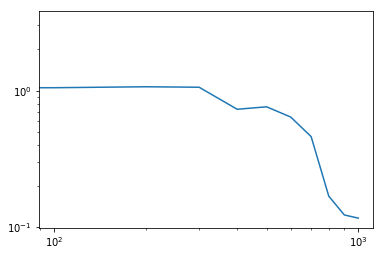

In [351]:
plt.loglog(loss_plot[0], loss_plot[1])

In [254]:
p = {'network_option':build_network5, 'num_iter':101, 'batch_size':10,
     'snr':-1, 'num_preambles':1, 'fixed_preamble':False, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2, 'lr':5e-5}
inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)

0 1.1312578
100 0.00052252505


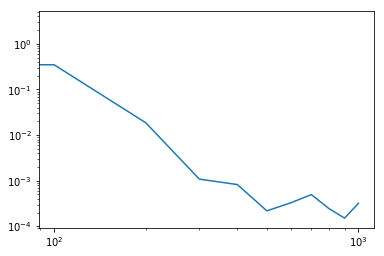

In [163]:
plt.loglog(loss_plot[0], loss_plot[1])

In [13]:
#preamble=gen_preamble()
#channels = gen_channel(N=1,length=2)
received = apply_channel(channels, preamble, snr=1e-2)
received_ = received[:,:-1].reshape((1,100,1))
print(preamble.shape, channels.shape, received.shape,received_.shape)

(1, 100) (1, 2) (1, 101) (1, 100, 1)


In [14]:
np.around(channels[0],5)

array([0.08857, 0.99607])

In [15]:
sess.run(outputs[0], feed_dict={inputs[0]:preamble.reshape((1, 100, 1)),
                         inputs[1]:received_})

array([[0.24885114, 0.99647313]], dtype=float32)

In [7]:
"""Computes the least squares channel estimate given X (sent data) and Y (received data after additive noise)."""
def LS_channel_est(x, y):
    x = x.T
    y=y.reshape((1,101,1))
    y=y[:,1:,0]
    x_mat = np.zeros((2, 100))
    for i in range(len(x)):
        x_mat[:,i] = x[i:i+2,0]
    x_mat = np.array(x_mat)
    return np.flip(np.dot(np.dot(y, x_mat.T), np.linalg.inv(np.dot(x_mat, x_mat.T))),1)

In [80]:
LS_channel_est(preamble, received[1])

array([[0.94114968, 0.29911016]])

## Plots (2 tap channels)

In [70]:
def gen_data_for_plot(sess, outputs, inputs, preamble=None):
    n = 300
    if preamble is None:
        n_repeat = 10
        preambles = [gen_preamble() for _ in range(n_repeat)]
    else:
        n_repeat = 1
        preambles = [preamble]
    rad = np.linspace(0, 0.5*np.pi, n)
    channels = np.vstack((np.cos(rad),np.sin(rad))).T
    snrs = np.logspace(-4,4,20)
    errors_nn = np.zeros((n*len(snrs)))
    errors_ls = np.zeros((n*len(snrs)))
    channel_x = np.zeros((n*len(snrs)))
    channel_y = np.zeros((n*len(snrs)))
    for i in range(len(snrs)):
        for preamble in preambles:
            s = snrs[i]
            received = apply_channel(channels, preamble, snr=s)
            received_ = received[:,:-1].reshape((n,100,1))
            channel_hat_nn = sess.run(outputs[0], feed_dict={inputs[0]:preamble.reshape((1, 100, 1)),
                                 inputs[1]:received_})
            for j in range(len(received)):
                channel_hat_ls[j] = LS_channel_est(preamble, received[j])

            errors_nn[i*n:(i+1)*n] += np.mean((channel_hat_nn - channels)**2,axis=1)
            errors_ls[i*n:(i+1)*n] += np.mean((channel_hat_ls - channels)**2,axis=1)
        errors_nn[i*n:(i+1)*n] /= n_repeat
        errors_ls[i*n:(i+1)*n] /= n_repeat

        channel_x[i*n:(i+1)*n] = channels[:,0]*s
        channel_y[i*n:(i+1)*n] = channels[:,1]*s
    
    return channel_x, channel_y, errors_nn, errors_ls
        
def heat_plot(channel_x, channel_y, errors_nn, errors_ls):
    X = channel_x
    Y = channel_y
    Z1 = np.log10(errors_nn)
    Z2 = np.log10(errors_ls)
    # create x-y points to be used in heatmap
    xi = np.logspace(-4, 4,100)
    yi = np.logspace(-4, 4,100)

    # Z is a matrix of x-y values
    zi1 = griddata((X, Y), Z1, (xi[None,:], yi[:,None]), method='linear')
    zi2 = griddata((X, Y), Z2, (xi[None,:], yi[:,None]), method='linear')

    # direction = channel, radius = SNR
    f, ax = plt.subplots(1, 2, figsize = (8*2, 6),sharex=True,sharey=True)
    ax[0].set_title('NN channel estimator L2 error, log scale')
    ax[1].set_title('LS channel estimator L2 error, log scale')
    CS1 = ax[0].contourf(xi, yi, zi1, 15, cmap=plt.cm.rainbow, vmin=-10, vmax=2)
    CS2 = ax[1].contourf(xi, yi, zi2, 15, cmap=plt.cm.rainbow, vmin=-10, vmax=2)

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')

    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    f.colorbar(CS, cax=cbar_ax)

    ax[0].set_xlabel("(tap 1 value) x (channel SNR), log scale")
    ax[1].set_xlabel("(tap 1 value) x (channel SNR), log scale")
    ax[0].set_ylabel("(tap 2 value) x (channel SNR), log scale")


    plt.show()
    plt.close()

## 1. Fixed preamble, Trained on no channel noise
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc1 -> channel_est
     [   |        |    ]

In [68]:
# Train network
p1 = {'network_option':build_network5, 'num_iter':3001, 'batch_size':10,
     'snr':-1, 'num_preambles':1, 'fixed_preamble':True, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2, 'lr':5e-5}
#inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)
res1 = train_net(p1)

0 1.0724268
100 0.000471043
200 6.2413186e-05
300 1.371659e-05
400 5.08113e-06
500 2.6288503e-06
600 4.7859826e-06
700 1.537961e-06
800 8.3035513e-07
900 8.324749e-07
1000 2.078747e-06
1100 1.4718551e-06
1200 8.85228e-07
1300 8.141853e-07
1400 6.8671625e-07
1500 5.8927e-07
1600 4.5353636e-07
1700 7.2310684e-07
1800 3.2339454e-07
1900 2.6667612e-07
2000 1.7073845e-07
2100 1.5638238e-07
2200 1.9404692e-07
2300 2.3500874e-07
2400 9.4166225e-08
2500 2.2848062e-07
2600 7.523111e-08
2700 1.3270581e-07
2800 1.6846352e-07
2900 8.565584e-08
3000 1.8819048e-07


In [ ]:
d1 = gen_data_for_plot(sess=res1[6],outputs=res1[1],inputs=res1[0],preamble=res1[5])

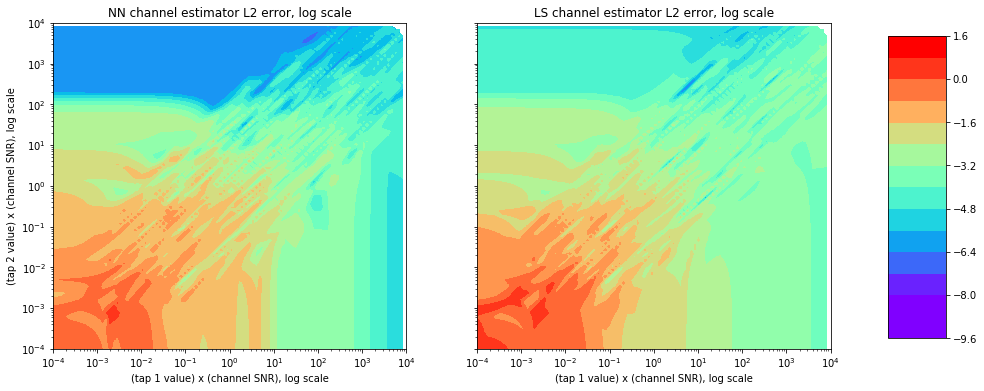

In [74]:
heat_plot(*d1)

## 2. Fixed preamble, Trained on moderate channel noise
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc1 -> channel_est
     [   |        |    ]

In [75]:
# Train network
p2 = {'network_option':build_network5, 'num_iter':3001, 'batch_size':10,
     'snr':1, 'num_preambles':1, 'fixed_preamble':True, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2, 'lr':5e-5}
#inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)
res2 = train_net(p2)

0 1.1514065
100 0.0023954245
200 0.0012523778
300 0.0006232939
400 0.00070090283
500 0.00018722194
600 0.00024024514
700 9.066441e-05
800 6.973099e-05
900 6.917941e-05
1000 5.23721e-05
1100 4.47728e-05
1200 6.0587772e-05
1300 2.2127466e-05
1400 4.2316893e-05
1500 4.1476284e-05
1600 3.9517272e-05
1700 1.4550742e-05
1800 5.4245545e-05
1900 1.6687187e-05
2000 3.450977e-05
2100 2.2026734e-05
2200 1.8232848e-05
2300 2.8397562e-05
2400 1.5074312e-05
2500 2.312628e-05
2600 1.5842925e-05
2700 8.44529e-06
2800 2.539627e-05
2900 1.701163e-05
3000 2.0527139e-05


In [76]:
d2 = gen_data_for_plot(sess=res2[6],outputs=res2[1],inputs=res2[0],preamble=res2[5])

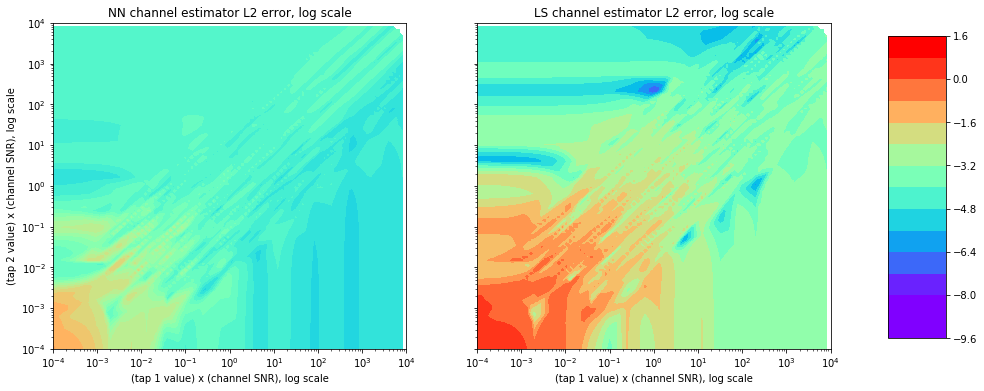

In [77]:
heat_plot(*d2)

## 3. Fixed preamble, Trained on large channel noise
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc1 -> channel_est
     [   |        |    ]

In [78]:
# Train network
p3 = {'network_option':build_network5, 'num_iter':3001, 'batch_size':10,
     'snr':1e-2, 'num_preambles':1, 'fixed_preamble':True, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2, 'lr':5e-5}
#inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)
res3 = train_net(p3)

0 3.4729953
100 0.3364288
200 0.003852474
300 0.0008327767
400 0.0006173305
500 0.000115438364
600 0.00023713945
700 0.00068612525
800 0.00013088874
900 0.00012852391
1000 0.0001978792
1100 0.0015329348
1200 0.00026732645
1300 0.0005042399
1400 0.00032740243
1500 0.00026708853
1600 8.907493e-05
1700 0.0001340948
1800 0.00013786637
1900 6.220871e-05
2000 0.00036674913
2100 0.0006812442
2200 0.0002418275
2300 0.0009091243
2400 0.034979336
2500 0.00033270736
2600 0.00021685455
2700 0.000919817
2800 4.470481e-05
2900 8.2247585e-05
3000 6.978659e-05


In [79]:
d3 = gen_data_for_plot(sess=res3[6],outputs=res3[1],inputs=res3[0],preamble=res3[5])

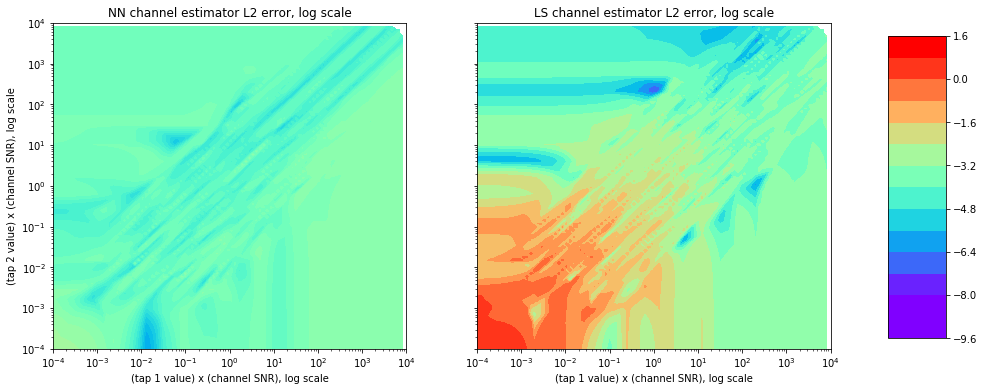

In [80]:
heat_plot(*d3)

In [90]:
# on preambles not trained on
d3_ = gen_data_for_plot(sess=res3[6],outputs=res3[1],inputs=res3[0],preamble=None)

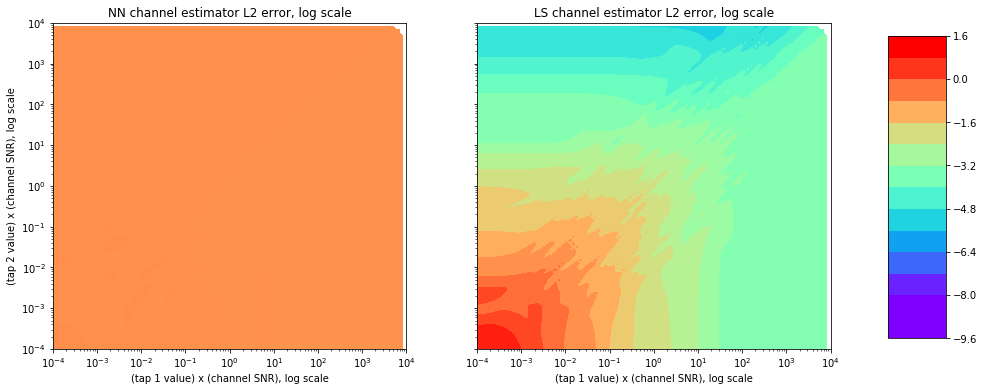

In [91]:
heat_plot(*d3_)

## 4. Non-fixed preamble, Trained on no channel noise
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc1-> channel_est
     [   |        |    ]

In [81]:
# Train network
p4 = {'network_option':build_network5, 'num_iter':3001, 'batch_size':10,
     'snr':-1, 'num_preambles':1, 'fixed_preamble':False, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2, 'lr':5e-5}
#inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)
res4 = train_net(p4)

0 1.0724268
100 0.6737922
200 0.09520279
300 0.014424084
400 0.015700333
500 0.0071197497
600 0.015440528
700 0.0105075445
800 0.0054653953
900 0.0011571876
1000 0.0060091633
1100 0.030421864
1200 0.008108348
1300 0.0058585624
1400 0.008355921
1500 0.011813849
1600 0.0023483473
1700 0.0071400506
1800 0.025404114
1900 0.008298348
2000 0.01812281
2100 0.0042430526
2200 0.0043476564
2300 0.015420908
2400 0.013796033
2500 0.0013736305
2600 0.005093568
2700 0.0063218013
2800 0.0042670015
2900 0.009280057
3000 0.0030432357


In [82]:
d4 = gen_data_for_plot(sess=res4[6],outputs=res4[1],inputs=res4[0],preamble=None)

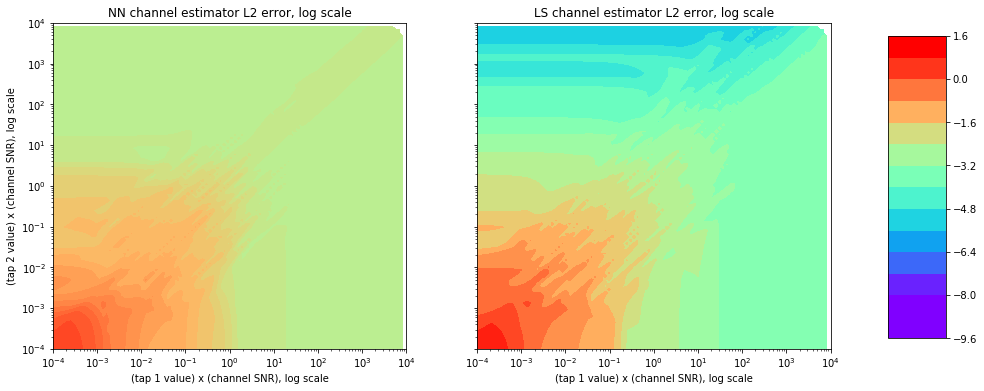

In [83]:
heat_plot(*d4)

## 5. Non-fixed preamble, Trained on moderate channel noise
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc1 -> channel_est
     [   |        |    ]

In [84]:
# Train network
p5 = {'network_option':build_network5, 'num_iter':3001, 'batch_size':10,
     'snr':1, 'num_preambles':1, 'fixed_preamble':False, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2, 'lr':5e-5}
#inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)
res5 = train_net(p5)

0 1.1514065
100 0.69045115
200 0.16252546
300 0.044181127
400 0.028580034
500 0.038005278
600 0.009060796
700 0.03419743
800 0.027674338
900 0.009716127
1000 0.022234028
1100 0.012345421
1200 0.006423282
1300 0.0060848994
1400 0.009579812
1500 0.020795614
1600 0.010161671
1700 0.012230652
1800 0.01745995
1900 0.011414975
2000 0.007041334
2100 0.0071651875
2200 0.010401839
2300 0.018831395
2400 0.025933102
2500 0.0051419334
2600 0.005859842
2700 0.004861651
2800 0.010099819
2900 0.0036126836
3000 0.020944383


In [85]:
d5 = gen_data_for_plot(sess=res5[6],outputs=res5[1],inputs=res5[0],preamble=None)

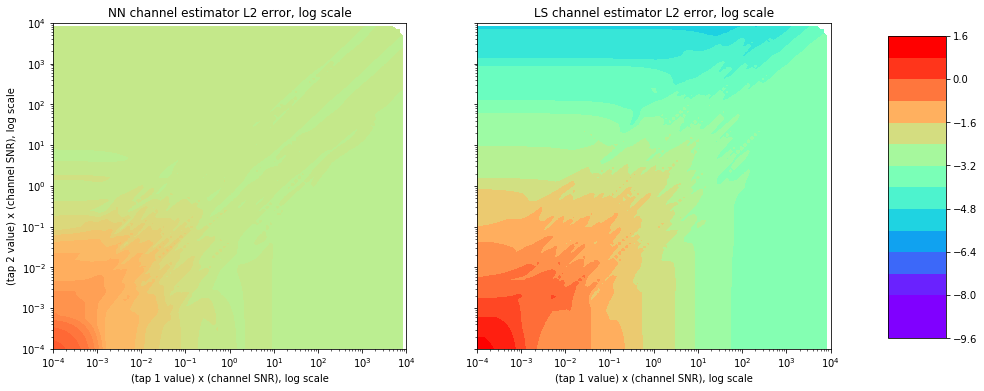

In [86]:
heat_plot(*d5)

## 6. Non-fixed preamble, Trained on large channel noise
     [   |        |    ]
     [preamble received] -> conv1 -> conv2 -> conv3 -> conv4 -> fc1 -> channel_est
     [   |        |    ]

In [87]:
# Train network
p6 = {'network_option':build_network5, 'num_iter':3001, 'batch_size':10,
     'snr':1e-2, 'num_preambles':1, 'fixed_preamble':False, 'num_taps':2, 
     'preamble_len':100, 'channel_len':2, 'lr':5e-5}
#inputs, outputs, weights, loss, train, preamble, sess, loss_plot = train_net(p)
res6 = train_net(p6)

0 3.4729953
100 1.1252655
200 0.8352226
300 0.7621023
400 0.82595146
500 0.8906029
600 0.38796562
700 0.38068086
800 0.23156281
900 0.12141992
1000 0.051028974
1100 0.027557492
1200 0.017553056
1300 0.048386674
1400 0.050918885
1500 0.09306973
1600 0.028290868
1700 0.03730951
1800 0.036482953
1900 0.035907816
2000 0.028314516
2100 0.016567338
2200 0.012131076
2300 0.049639285
2400 0.04033941
2500 0.01368438
2600 0.023752928
2700 0.02841061
2800 0.015092907
2900 0.09551466
3000 0.06973417


In [88]:
d6 = gen_data_for_plot(sess=res6[6],outputs=res6[1],inputs=res6[0],preamble=None)

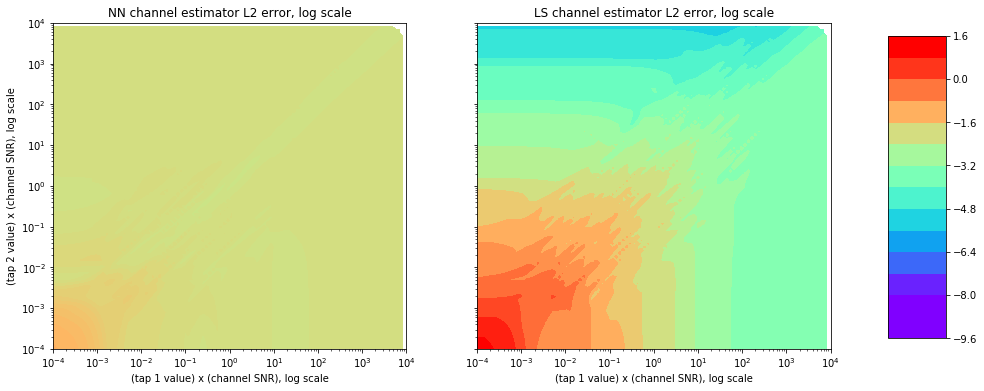

In [89]:
heat_plot(*d6)